#### Loading the data

The data from 2 files is merged on track id using pandas.

In [17]:
import pandas as pd

metrics_data = pd.read_csv('datasets/fma-rock-vs-hiphop.csv')
track_data = pd.read_json('datasets/echonest-metrics.json',precise_float=True)

# print(metrics_data.head(2))
# print(track_data.head(2))

df = pd.merge(track_data,metrics_data[['track_id','genre_top']],on='track_id')

print(df.info())
df.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB
None


,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
3,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop
4,153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock


#### Finding the correlation matrix

In [18]:
correlation = df.corr()
correlation.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


Since the features are not much related, we use PCA to reduce dimensionality!
but first we normalise the features.

#### Normalising the Data

In [19]:
from sklearn.preprocessing import StandardScaler
features = df.drop(['genre_top','track_id'],axis=1)
labels = df['genre_top']

scaler = StandardScaler()
Transformed_data = scaler.fit_transform(features)

#### Dimension reduction

<BarContainer object of 8 artists>

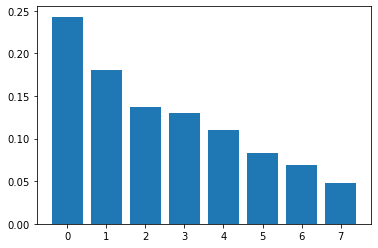

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()
pca.fit(Transformed_data)
var = pca.explained_variance_ratio_

fig,ax = plt.subplots()
ax.bar(range(8),var)

Since the plot is not giving much insight about the var, we use cumulative variance.


only the components that are near 85% variance.

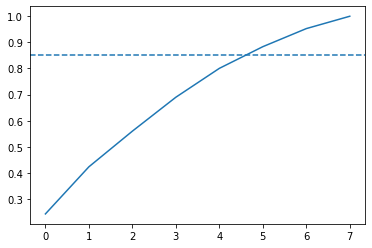

In [21]:
import numpy as np
cum_var = np.cumsum(var)

fig, ax = plt.subplots()
ax.plot(range(8),cum_var)
ax.axhline(y=0.85, linestyle='--')

6 components are chosen

In [22]:
n_components = 6
pca = PCA(n_components, random_state=10)
pca.fit(Transformed_data)
Transformed_data_1 = pca.transform(Transformed_data)

#### Training the Decision Tree model

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

train_data, test_data, train_labels, test_labels = train_test_split(Transformed_data_1,labels,random_state=10)
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_data,train_labels)

pred_labels_tree = tree.predict(test_data)
class_rp = classification_report(test_labels, pred_labels)
print("Decision Classifier: \n", class_rp)

Decision Classifier: 
               precision    recall  f1-score   support

     Hip-Hop       0.60      0.60      0.60       235
        Rock       0.90      0.90      0.90       966

    accuracy                           0.84      1201
   macro avg       0.75      0.75      0.75      1201
weighted avg       0.84      0.84      0.84      1201



for better insights, training the data on Logistic Regression 
#### Training the model on Logreg

In [25]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(train_data, train_labels)
pred_labels_logreg = logreg.predict(test_data)

class_rp_logreg = classification_report(test_labels,pred_labels_logreg)
class_rp_tree = classification_report(test_labels,pred_labels_tree)

print("Decison Tree: \n",class_rp_tree)
print("Logistic Regression: \n", class_rp_logreg)

Decison Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.60      0.60      0.60       235
        Rock       0.90      0.90      0.90       966

    accuracy                           0.84      1201
   macro avg       0.75      0.75      0.75      1201
weighted avg       0.84      0.84      0.84      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.77      0.54      0.64       235
        Rock       0.90      0.96      0.93       966

    accuracy                           0.88      1201
   macro avg       0.83      0.75      0.78      1201
weighted avg       0.87      0.88      0.87      1201



Now we find that both the models are performing equivalent good!!

But the report shows the data is skewed towards Rock

#### Balancing the Data

In [29]:
hop_only = df.loc[df['genre_top']=='Hip-Hop']
rock_only = df.loc[df['genre_top']=='Rock'].sample(len(hop_only),random_state=10)

df_1 = pd.concat([hop_only,rock_only])

data = df_1.drop(['genre_top','track_id'],axis=1)
labels = df_1['genre_top']

Transformed_data = pca.fit_transform(scaler.fit_transform(data))

train_data, test_data, train_labels, test_labels = train_test_split(Transformed_data,labels,random_state=10)

#### Model comparison

In [30]:
tree = DecisionTreeClassifier()
logreg = LogisticRegression()

tree.fit(train_data,train_labels)
pred_labels_tree = tree.predict(test_data)

logreg.fit(train_data,train_labels)
pred_labels_logreg = logreg.predict(test_data)

print("Decision Tree: \n", classification_report(test_labels,pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels,pred_labels_logreg))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.76      0.80      0.78       225
        Rock       0.79      0.75      0.77       230

    accuracy                           0.77       455
   macro avg       0.77      0.77      0.77       455
weighted avg       0.77      0.77      0.77       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.83      0.80      0.82       225
        Rock       0.81      0.84      0.83       230

    accuracy                           0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.82      0.82      0.82       455



#### Cross-validation evaluation

In [35]:
from sklearn.model_selection import KFold, cross_val_score
kf = KFold(n_splits=10)

tree = DecisionTreeClassifier(random_state=10)
logreg = LogisticRegression(random_state=10)

tree_score = cross_val_score(tree,Transformed_data,labels,cv=kf)
logit_score = cross_val_score(logreg,Transformed_data,labels,cv=kf)

print("Decison Tree:",np.mean(tree_score))
print("Logistic Regression",np.mean(logit_score))

Decison Tree: 0.7489010989010989
Logistic Regression 0.782967032967033
